# Lecture : Graph Generation Models

## Lab 01 : Variational autoencoders (VAE) for mixture of Gaussians

### Xavier Bresson, Nian Liu


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/11_Graph_Generation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time
#import utils
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings
import os, datetime

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.0.1+cu118
NVIDIA GeForce RTX 4090 Laptop GPU
cuda:0


/home/bcjr1997/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Create artifical dataset of mixture of Gaussians

num_x, range_x, step_x, x :  100 20 0.40404040404040403 torch.Size([100])
num_gaussians :  2
train_data, bs, num_batch :  torch.Size([4000, 100]) 100 40
train_data :  torch.Size([4000, 100])
max, min, mean :  tensor(1.) tensor(-1.) tensor(-0.7510)


<Figure size 432x288 with 0 Axes>

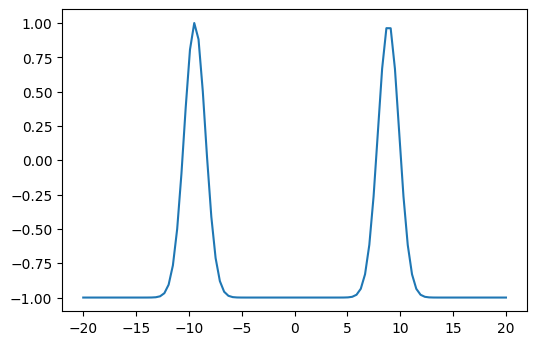

<Figure size 432x288 with 0 Axes>

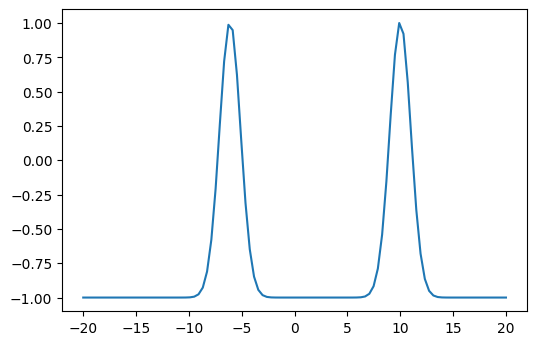

In [3]:
# Parameters of the mixture of Gaussians
num_data = 4000
num_x = 100
range_x = 20
step_x = 2 * range_x / (num_x - 1)
x = torch.arange(-range_x,range_x+step_x,step_x)
print('num_x, range_x, step_x, x : ',num_x, range_x, step_x, x.size())
num_gaussians = 2
print('num_gaussians : ', num_gaussians)
train_data = torch.zeros(num_data, num_x)
bs = 100
num_batch = num_data//bs
print('train_data, bs, num_batch : ', train_data.size(), bs, num_batch)

for k in range(num_batch):
    mu = torch.zeros(num_gaussians, bs)
    mu[0,:] = torch.FloatTensor(bs).uniform_(-15, -5)
    mu[1,:] = torch.FloatTensor(bs).uniform_(5, 15)   
    mu_batch = mu.unsqueeze(2)
    sigma = torch.ones(num_gaussians, bs)
    sigma_batch = sigma.unsqueeze(2)
    x_batch = x.repeat(num_gaussians, bs, 1)
    p = torch.exp( - (x_batch - mu_batch)**2 / (2* sigma_batch**2) ) / torch.sqrt( 2* torch.pi* sigma_batch**2 )
    p = p.sum(0); p /= p.sum(1).unsqueeze(1)
    p = ( p - p.min(1)[0].unsqueeze(1) ) / ( p.max(1)[0].unsqueeze(1) - p.min(1)[0].unsqueeze(1) )
    p = 2 * ( p - 0.5 )
    train_data[k*bs:(k+1)*bs, :] = p
print('train_data : ',train_data.size())
print('max, min, mean : ',train_data.max(), train_data.min(), train_data.mean())

plt.figure(2)
plt.figure(dpi=100)
plt.plot(x, train_data[0])
plt.show()
plt.figure(3)
plt.figure(dpi=100)
plt.plot(x, train_data[1])
plt.show()


# VAE [1] with Transformers [2]

[1] Kingma, Welling, Auto-Encoding Variational Bayes, 2013, https://arxiv.org/pdf/1312.6114  
[2] Vaswani et-al, Attention Is All You Need, 2017, https://arxiv.org/pdf/1706.03762


In [4]:
# Global constants
N = train_data.size(0) # number of training data
n = train_data.size(1) # number of elements in the line 
print('N, n : ', N, n)

dz = 32 # number of dimensions for the compressed representation
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers_encoder = 2 # number of transformer encoder layers
num_layers_decoder = 2 # number of transformer decoder layers
drop = 0.01 # dropout value
bs = 50 # batch size
print('dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs : ', \
      dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs)


N, n :  4000 100
dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs :  32 4 128 2 2 0.01 50


# Question 1: Design vanilla Transformers

#### Step 1: Code single-head attention layer in ```class head_attention(nn.Module)```. The formula is 
\begin{eqnarray*}
&&\quad\quad\ \textrm{Attention}(h)=\textrm{Softmax}\left(\frac{QK^T}{\sqrt{d'}} \right) V \in \mathbb{R}^{N\times d\_head}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d\_head}, W_Q, W_K, W_V\in \mathbb{R}^{d\times d\_head}
\end{eqnarray*}

- In this code, we consider a batch of data $x\in\mathbb{R}^{B\times N\times d}$. Process the correct dimension when calculating attention.
- We also employ one ```nn.Dropout()``` on the attention score matrix.

#### Step 2: Construct the multi-head attention layer in ```class MHA(nn.Module)``` by concatenating multiple ```head_attention```. 
\begin{eqnarray*}
\textrm{MHA}(h)=\textrm{Concat}_{k=1}^H \left( \textrm{Attention}(h_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d\_head}, W_O\in \mathbb{R}^{d\times d} \\
\end{eqnarray*}

- One dropout layer is needed upon the output node embeddings.

#### Step 3: Implement a complete Transformer block in ```class BlockGT(nn.Module)``` following:
\begin{eqnarray*}
\bar{h}^{\ell} &=&  h^{\ell} + \textrm{MHA} (\textrm{LN}(h^{\ell})) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell})) \in \mathbb{R}^{N\times d}
\end{eqnarray*}

- Notice the positions of the two layer normalization layers.
  

In [5]:
# Define VAE architecture with Transformers
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
    def forward(self, x):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        Q = self.Q(x).unsqueeze(2) # [bs, n, 1, d_head]
        K = self.K(x).unsqueeze(1) # [bs, 1, n, d_head]
        V = self.V(x)
        attention = ((Q * K).sum(dim=3) / self.sqrt_d) # Attention Score Matrix, [bs, n, n]
        attention = torch.softmax(attention, dim=1)
        attention = self.drop_att(attention)
        x = attention @ V # [bs, n, d_head]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return x

class MHA(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
    def forward(self, x):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        attentions = []
        x_in = x
        for head in self.heads: # [bs, n, d_head]
            x = head(x_in)
            attentions.append(x)
        x = torch.cat(attentions, dim=2)
        x = self.WOx(x)
        x = self.drop_x(x)# [bs, n, d]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return x

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
    def forward(self, x):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        x_in = x
        x = self.LNx(x)
        x = x_in + self.MHA(x)
        x = self.LNx2(x)
        x = x + self.MLPx(x)
        x = self.drop_x_mlp(x)# [bs, n, d]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return x


# Question 2: Implement the VAE architecture

#### Step 1: Initialize encoder and decoder networks using above ```BlockGT```.

#### Step 2: Encode the input as a distribution.

For the training phase
- Get the embedding for each data point via the encoder network.
- Average these embeddings to get one vector to represent the whole input data.
- Employ two MLPs on the data representation to get the mean vector and the log variance vector, separately.
- Use the re-parameterization trick to get one sample ```z``` from the distribution (defined by got mean and log variance vectors).
  
For generation phase, directly sample ```z``` from the normal distribution. Use [torch.Tensor.normal_()](https://pytorch.org/docs/stable/generated/torch.Tensor.normal_.html#torch.Tensor.normal_).

#### Step 3: Decode the hidden ```z``` into the original space.
- In this code, the dimensions of `z` and `h` are not same. So, an additional MLP is required to map `z` to `h`.
- If positional encoding (PE) is a part of input for generator, we also input the same dimensions of PE into the decoder.
  

In [6]:
class VAE(nn.Module): 
    def __init__(self):
        super().__init__()
        self.pe_x = nn.Embedding(n, d)
        self.h_emb = nn.Linear(1, d)
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        self.gt_enc_layers = nn.ModuleList([BlockGT(d, num_heads) for _ in range(num_layers_encoder)])
        self.gt_dec_layers = nn.ModuleList([BlockGT(d, num_heads) for _ in range(num_layers_decoder)])
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        self.drop_x_emb = nn.Dropout(drop)
        self.drop_p_emb = nn.Dropout(drop)
        self.linear_q_mu     = nn.Linear(d, dz)
        self.linear_q_logvar = nn.Linear(d, dz)
        self.linear_p = nn.Linear(dz, d) 
        self.ln_final = nn.LayerNorm(d)  
        self.linear_final = nn.Linear(d, 1)
    def forward(self, h, train=True, num_gen=1):
        if train: # training phase
            # input layer
            h = self.h_emb(h.unsqueeze(2))                    # [bs, n, d]
            bs2 = h.size(0)
            pe_x = torch.arange(0,n).to(device).repeat(bs2,1) # [bs, n] 
            pe_x = self.pe_x(pe_x)                            # [bs, n, d] 
            h = h + pe_x                                      # [bs, n, d]
            # encoder
            ###############################################
            # According to Step 2, finish encoding process
            # YOUR CODE STARTS
            ###############################################
            for layer in self.gt_enc_layers:
                h = layer(h)
            # Select up to N sequence because we only care about those that 
            # are affected by Positional Encoding and average the values
            h_token = h[:, :n, :].mean(1) 
            q_mu = self.linear_q_mu(h_token) # [bs, dz]
            q_logvar = self.linear_q_logvar(h_token) # [bs, dz]
            q_std = torch.exp(0.5 * q_logvar)
            eps = torch.randn_like(q_std) 
            z = q_mu + eps * q_std # [bs, dz]
            ###############################################
            # YOUR CODE ENDS
            ###############################################
            bs_dec = bs
        else: # generation phase
            bs_dec = num_gen
            pe_x = torch.arange(0,n).to(device).repeat(bs_dec,1) # [bs, n] 
            pe_x = self.pe_x(pe_x)                               # [bs, n, d] 
            ###############################################
            # Directly sample `z` from normal distribution, the shape is [number of samples to generate, hidden dimension of `z`]
            # YOUR CODE STARTS
            ###############################################
            z = torch.Tensor(num_gen, dz).normal_().to(device)# [b, dz]
            ###############################################
            # YOUR CODE ENDS
            ###############################################
            q_mu, q_logvar = _, _
        # decoder
        ###############################################
        # According to Step 3, finish decoding process
        # YOUR CODE STARTS
        ###############################################
        z = self.linear_p(z).view(bs_dec, 1, d)
        z = z + pe_x[:bs_dec, :, :]
        for layer in self.gt_dec_layers:
            z = layer(z)
        h = z# [bs, n, d]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        # output
        h = self.ln_final(h)                                 # [bs, n, d]
        h = self.linear_final(h).squeeze()                   # [bs, n]
        return h, q_mu, q_logvar


# Instantiate the network
net = VAE()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)
idx_data = torch.LongTensor(bs).random_(0,N)
batch_x0 = train_data[idx_data,:].to(device) # [bs, n]
print('batch_x0',batch_x0.size())
batch_x_pred, q_mu, q_logvar = net(batch_x0) # [bs, n]
print('batch_x_pred',batch_x_pred.size())
loss_data = torch.nn.MSELoss()(batch_x_pred, batch_x0)
loss_KL = -0.5* torch.mean( 1.0 + q_logvar - q_mu.pow(2.0) - q_logvar.exp() )
loss_VAE = 1* loss_data + loss_KL
loss = loss_VAE
optimizer.zero_grad()
loss.backward()
optimizer.step()

# generate new data
with torch.no_grad():
    num_data = 4
    batch_x_gen = net(None, False, num_data)[0] # [num_data, n]
    print('batch_x_gen',batch_x_gen.size())

Number of parameters: 819009 (0.82 million)
batch_x0 torch.Size([50, 100])
batch_x_pred torch.Size([50, 100])
batch_x_gen torch.Size([4, 100])


# Question 3: Code training loss of VAE

The loss includes fidelity loss and regularization loss
\begin{eqnarray*}
&&\textrm{Fidelity Loss: } \max_{\theta, \phi}\mathbb{E}_{z\sim q_\phi(z|x)} (\log p_\theta(x|z))=\min\limits_{\theta, \phi} \textrm{MSE}(x, \hat{x})\\
&&\textrm{Regularization loss: } -KL(q_\phi(z|x), p(z))=\frac{1}{2}\sum\limits_{j=1}^{d_z}(1+(\log\sigma^2_{z|x})_j-(\mu_{z|x})^2_j-(\sigma^2_{z|x})_j)
\end{eqnarray*}


Number of parameters: 819009 (0.82 million)
epoch= 0 	 time= 0.0316 min 	 lr= 0.0003 	 loss= 7.8460
epoch= 1 	 time= 0.0612 min 	 lr= 0.0003 	 loss= 2.5881
epoch= 2 	 time= 0.0905 min 	 lr= 0.0003 	 loss= 2.5732
epoch= 3 	 time= 0.1203 min 	 lr= 0.0003 	 loss= 2.5645
epoch= 4 	 time= 0.1502 min 	 lr= 0.0003 	 loss= 2.5556
epoch= 5 	 time= 0.1863 min 	 lr= 0.0003 	 loss= 2.5497
epoch= 6 	 time= 0.2213 min 	 lr= 0.0003 	 loss= 2.5411
epoch= 7 	 time= 0.2572 min 	 lr= 0.0003 	 loss= 2.5421
epoch= 8 	 time= 0.2921 min 	 lr= 0.0003 	 loss= 2.5357
epoch= 9 	 time= 0.3264 min 	 lr= 0.0003 	 loss= 2.5347
epoch= 10 	 time= 0.3626 min 	 lr= 0.0003 	 loss= 2.5284


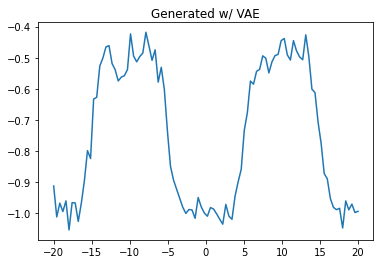

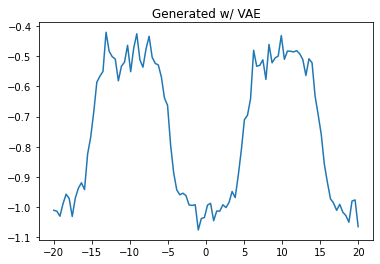

epoch= 11 	 time= 0.3995 min 	 lr= 0.0003 	 loss= 2.5292
epoch= 12 	 time= 0.4340 min 	 lr= 0.0003 	 loss= 2.5273
epoch= 13 	 time= 0.4658 min 	 lr= 0.0003 	 loss= 2.5260
epoch= 14 	 time= 0.4970 min 	 lr= 0.0003 	 loss= 2.5203
epoch= 15 	 time= 0.5306 min 	 lr= 0.0003 	 loss= 2.5241
epoch= 16 	 time= 0.5616 min 	 lr= 0.0003 	 loss= 2.5199
epoch= 17 	 time= 0.5931 min 	 lr= 0.0003 	 loss= 2.5147
epoch= 18 	 time= 0.6297 min 	 lr= 0.0003 	 loss= 2.5156
epoch= 19 	 time= 0.6685 min 	 lr= 0.0003 	 loss= 2.5133
epoch= 20 	 time= 0.7066 min 	 lr= 0.0003 	 loss= 2.5130


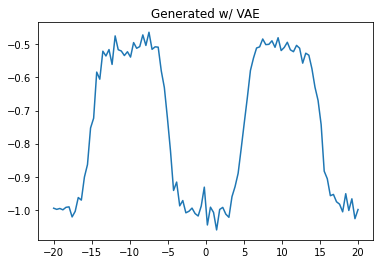

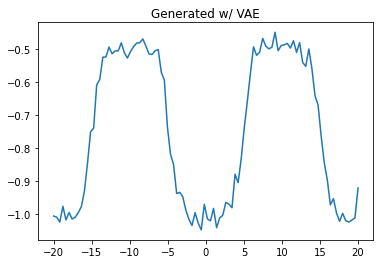

epoch= 21 	 time= 0.7487 min 	 lr= 0.0003 	 loss= 2.5156
epoch= 22 	 time= 0.7845 min 	 lr= 0.0003 	 loss= 2.5070
epoch= 23 	 time= 0.8159 min 	 lr= 0.0003 	 loss= 2.5069
Epoch 00025: reducing learning rate of group 0 to 2.8500e-04.
epoch= 24 	 time= 0.8468 min 	 lr= 0.000285 	 loss= 2.5079
epoch= 25 	 time= 0.8776 min 	 lr= 0.000285 	 loss= 2.5045
epoch= 26 	 time= 0.9085 min 	 lr= 0.000285 	 loss= 2.5034
epoch= 27 	 time= 0.9404 min 	 lr= 0.000285 	 loss= 2.5011
epoch= 28 	 time= 0.9716 min 	 lr= 0.000285 	 loss= 2.5019
epoch= 29 	 time= 1.0032 min 	 lr= 0.000285 	 loss= 2.4988
epoch= 30 	 time= 1.0374 min 	 lr= 0.000285 	 loss= 2.4989


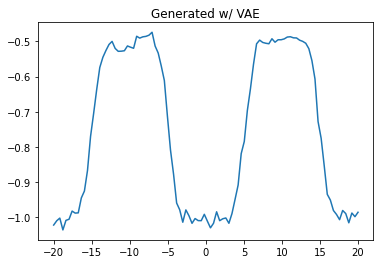

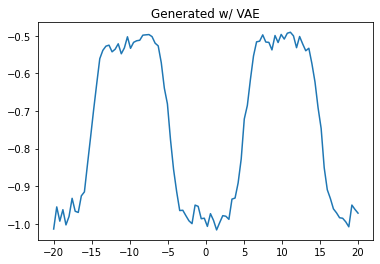

Epoch 00032: reducing learning rate of group 0 to 2.7075e-04.
epoch= 31 	 time= 1.0773 min 	 lr= 0.00027075 	 loss= 2.4989
epoch= 32 	 time= 1.1132 min 	 lr= 0.00027075 	 loss= 2.4959
epoch= 33 	 time= 1.1480 min 	 lr= 0.00027075 	 loss= 2.4952
epoch= 34 	 time= 1.1835 min 	 lr= 0.00027075 	 loss= 2.4929
epoch= 35 	 time= 1.2184 min 	 lr= 0.00027075 	 loss= 2.4894
epoch= 36 	 time= 1.2521 min 	 lr= 0.00027075 	 loss= 2.4889
epoch= 37 	 time= 1.2834 min 	 lr= 0.00027075 	 loss= 2.4897
epoch= 38 	 time= 1.3146 min 	 lr= 0.00027075 	 loss= 2.4886
epoch= 39 	 time= 1.3459 min 	 lr= 0.00027075 	 loss= 2.4843
epoch= 40 	 time= 1.3774 min 	 lr= 0.00027075 	 loss= 2.4861


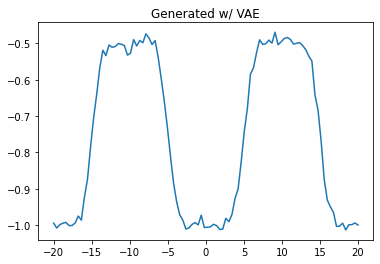

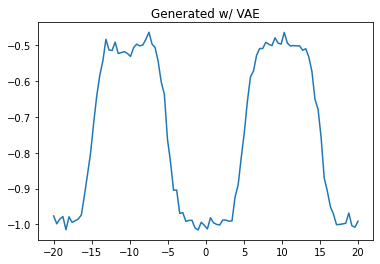

epoch= 41 	 time= 1.4108 min 	 lr= 0.00027075 	 loss= 2.4835
epoch= 42 	 time= 1.4465 min 	 lr= 0.00027075 	 loss= 2.4847
Epoch 00044: reducing learning rate of group 0 to 2.5721e-04.
epoch= 43 	 time= 1.4830 min 	 lr= 0.0002572125 	 loss= 2.4841
epoch= 44 	 time= 1.5216 min 	 lr= 0.0002572125 	 loss= 2.4805
epoch= 45 	 time= 1.5568 min 	 lr= 0.0002572125 	 loss= 2.4804
epoch= 46 	 time= 1.5918 min 	 lr= 0.0002572125 	 loss= 2.4796
epoch= 47 	 time= 1.6264 min 	 lr= 0.0002572125 	 loss= 2.4799
epoch= 48 	 time= 1.6608 min 	 lr= 0.0002572125 	 loss= 2.4757
epoch= 49 	 time= 1.6925 min 	 lr= 0.0002572125 	 loss= 2.4756
epoch= 50 	 time= 1.7232 min 	 lr= 0.0002572125 	 loss= 2.4740


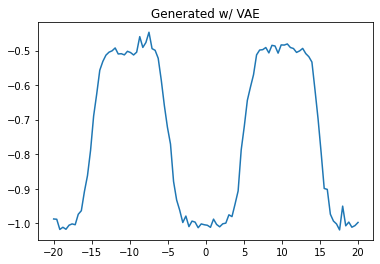

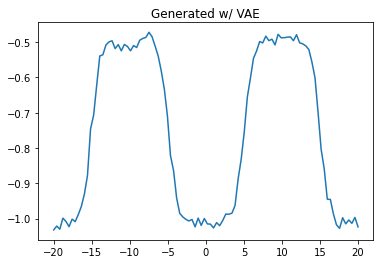

epoch= 51 	 time= 1.7565 min 	 lr= 0.0002572125 	 loss= 2.4741
epoch= 52 	 time= 1.7870 min 	 lr= 0.0002572125 	 loss= 2.4717
epoch= 53 	 time= 1.8180 min 	 lr= 0.0002572125 	 loss= 2.4706
epoch= 54 	 time= 1.8496 min 	 lr= 0.0002572125 	 loss= 2.4719
Epoch 00056: reducing learning rate of group 0 to 2.4435e-04.
epoch= 55 	 time= 1.8859 min 	 lr= 0.000244351875 	 loss= 2.4709
epoch= 56 	 time= 1.9207 min 	 lr= 0.000244351875 	 loss= 2.4667
epoch= 57 	 time= 1.9559 min 	 lr= 0.000244351875 	 loss= 2.4669
Epoch 00059: reducing learning rate of group 0 to 2.3213e-04.
epoch= 58 	 time= 1.9913 min 	 lr= 0.00023213428124999998 	 loss= 2.4665
epoch= 59 	 time= 2.0262 min 	 lr= 0.00023213428124999998 	 loss= 2.4646
epoch= 60 	 time= 2.0617 min 	 lr= 0.00023213428124999998 	 loss= 2.4649


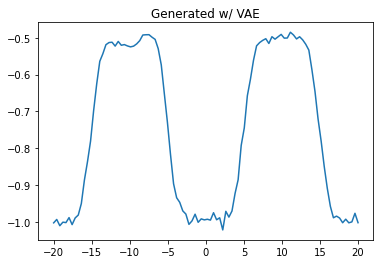

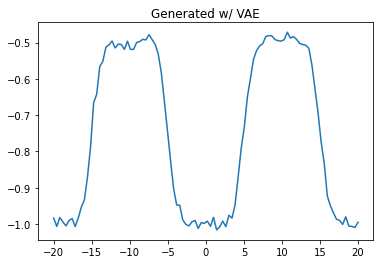

epoch= 61 	 time= 2.0957 min 	 lr= 0.00023213428124999998 	 loss= 2.4620
epoch= 62 	 time= 2.1264 min 	 lr= 0.00023213428124999998 	 loss= 2.4635
Epoch 00064: reducing learning rate of group 0 to 2.2053e-04.
epoch= 63 	 time= 2.1572 min 	 lr= 0.00022052756718749997 	 loss= 2.4636
epoch= 64 	 time= 2.1879 min 	 lr= 0.00022052756718749997 	 loss= 2.4586
epoch= 65 	 time= 2.2188 min 	 lr= 0.00022052756718749997 	 loss= 2.4595
Epoch 00067: reducing learning rate of group 0 to 2.0950e-04.
epoch= 66 	 time= 2.2504 min 	 lr= 0.00020950118882812497 	 loss= 2.4591
epoch= 67 	 time= 2.2850 min 	 lr= 0.00020950118882812497 	 loss= 2.4580
epoch= 68 	 time= 2.3193 min 	 lr= 0.00020950118882812497 	 loss= 2.4568
epoch= 69 	 time= 2.3538 min 	 lr= 0.00020950118882812497 	 loss= 2.4566
epoch= 70 	 time= 2.3932 min 	 lr= 0.00020950118882812497 	 loss= 2.4553


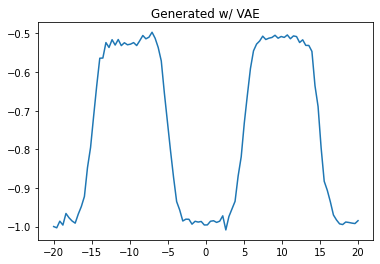

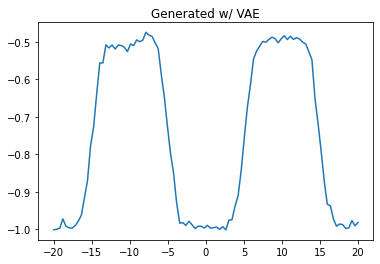

epoch= 71 	 time= 2.4379 min 	 lr= 0.00020950118882812497 	 loss= 2.4554
epoch= 72 	 time= 2.4782 min 	 lr= 0.00020950118882812497 	 loss= 2.4536
epoch= 73 	 time= 2.5110 min 	 lr= 0.00020950118882812497 	 loss= 2.4537
Epoch 00075: reducing learning rate of group 0 to 1.9903e-04.
epoch= 74 	 time= 2.5447 min 	 lr= 0.00019902612938671872 	 loss= 2.4534
epoch= 75 	 time= 2.5798 min 	 lr= 0.00019902612938671872 	 loss= 2.4519
epoch= 76 	 time= 2.6143 min 	 lr= 0.00019902612938671872 	 loss= 2.4528
epoch= 77 	 time= 2.6458 min 	 lr= 0.00019902612938671872 	 loss= 2.4513
epoch= 78 	 time= 2.6780 min 	 lr= 0.00019902612938671872 	 loss= 2.4519
Epoch 00080: reducing learning rate of group 0 to 1.8907e-04.
epoch= 79 	 time= 2.7147 min 	 lr= 0.00018907482291738277 	 loss= 2.4516
epoch= 80 	 time= 2.7507 min 	 lr= 0.00018907482291738277 	 loss= 2.4499


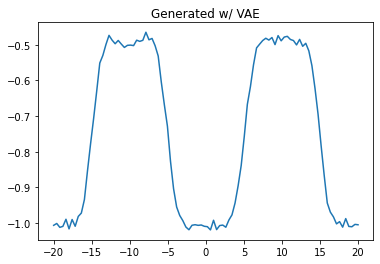

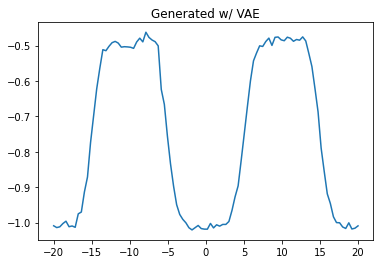

epoch= 81 	 time= 2.7935 min 	 lr= 0.00018907482291738277 	 loss= 2.4493
epoch= 82 	 time= 2.8298 min 	 lr= 0.00018907482291738277 	 loss= 2.4488
epoch= 83 	 time= 2.8657 min 	 lr= 0.00018907482291738277 	 loss= 2.4477
epoch= 84 	 time= 2.9014 min 	 lr= 0.00018907482291738277 	 loss= 2.4475
Epoch 00086: reducing learning rate of group 0 to 1.7962e-04.
epoch= 85 	 time= 2.9319 min 	 lr= 0.0001796210817715136 	 loss= 2.4476
epoch= 86 	 time= 2.9651 min 	 lr= 0.0001796210817715136 	 loss= 2.4461
epoch= 87 	 time= 2.9971 min 	 lr= 0.0001796210817715136 	 loss= 2.4462
Epoch 00089: reducing learning rate of group 0 to 1.7064e-04.
epoch= 88 	 time= 3.0299 min 	 lr= 0.00017064002768293793 	 loss= 2.4461
epoch= 89 	 time= 3.0645 min 	 lr= 0.00017064002768293793 	 loss= 2.4451
epoch= 90 	 time= 3.0961 min 	 lr= 0.00017064002768293793 	 loss= 2.4449


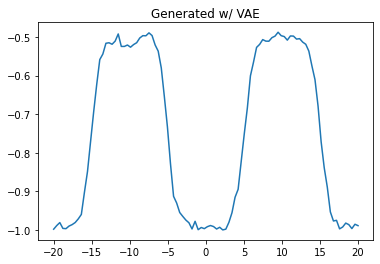

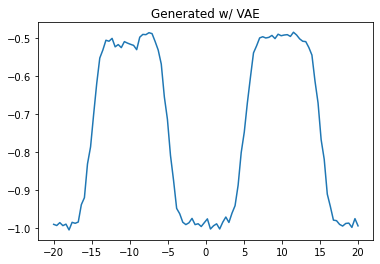

epoch= 91 	 time= 3.1351 min 	 lr= 0.00017064002768293793 	 loss= 2.4445
epoch= 92 	 time= 3.1740 min 	 lr= 0.00017064002768293793 	 loss= 2.4450
epoch= 93 	 time= 3.2121 min 	 lr= 0.00017064002768293793 	 loss= 2.4438
epoch= 94 	 time= 3.2488 min 	 lr= 0.00017064002768293793 	 loss= 2.4432
epoch= 95 	 time= 3.2852 min 	 lr= 0.00017064002768293793 	 loss= 2.4429
epoch= 96 	 time= 3.3197 min 	 lr= 0.00017064002768293793 	 loss= 2.4432
Epoch 00098: reducing learning rate of group 0 to 1.6211e-04.
epoch= 97 	 time= 3.3528 min 	 lr= 0.00016210802629879103 	 loss= 2.4435
epoch= 98 	 time= 3.3839 min 	 lr= 0.00016210802629879103 	 loss= 2.4414
epoch= 99 	 time= 3.4157 min 	 lr= 0.00016210802629879103 	 loss= 2.4409


In [7]:
# Training loop
del net
net = VAE()
net = net.to(device)
_ = display_num_param(net)

# Optimizer
init_lr = 0.0003
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

# Number of mini-batches per epoch
nb_epochs = 100
start = time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0

    shuffled_indices = torch.randperm(N)
    for count in range(0,N,bs):

        idx_data = shuffled_indices[count : count+bs]
        batch_x0 = train_data[idx_data,:].to(device) # [bs, n]
        batch_x_pred, q_mu, q_logvar = net(batch_x0) # [bs, n]     
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        loss_data = torch.nn.MSELoss()(batch_x0, batch_x_pred)
        loss_KL = -0.5 * torch.sum(1 + q_logvar - q_mu ** 2 - torch.exp(q_logvar))
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        loss_VAE = 10 * loss_data + loss_KL 
        loss = loss_VAE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute stats
        running_loss += loss.detach().item()
        num_batches += 1

    # Average stats
    mean_loss = running_loss/num_batches
    scheduler.step(mean_loss)
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', str(elapsed)[:6],'min', '\t lr=', optimizer.param_groups[0]['lr']  ,'\t loss=', str(mean_loss)[:6] )

    # Plot intermediate generated data
    if not epoch%10 and epoch>0:
        x_fake = net(None, False, 2)[0]
        plt.plot(x, x_fake[0].detach().cpu()); plt.title("Generated w/ VAE"); plt.show()
        plt.plot(x, x_fake[1].detach().cpu()); plt.title("Generated w/ VAE"); plt.show()

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 10**-4: 
      print("\n lr is equal to min lr -- training stopped\n")
      break




# Question 4: Generate new data

Hint: use the VAE model `net()`, set `train` as False, and set `num_gen` as the number of generative samples.


batch_x_0 torch.Size([16, 100])


<Figure size 1200x800 with 0 Axes>

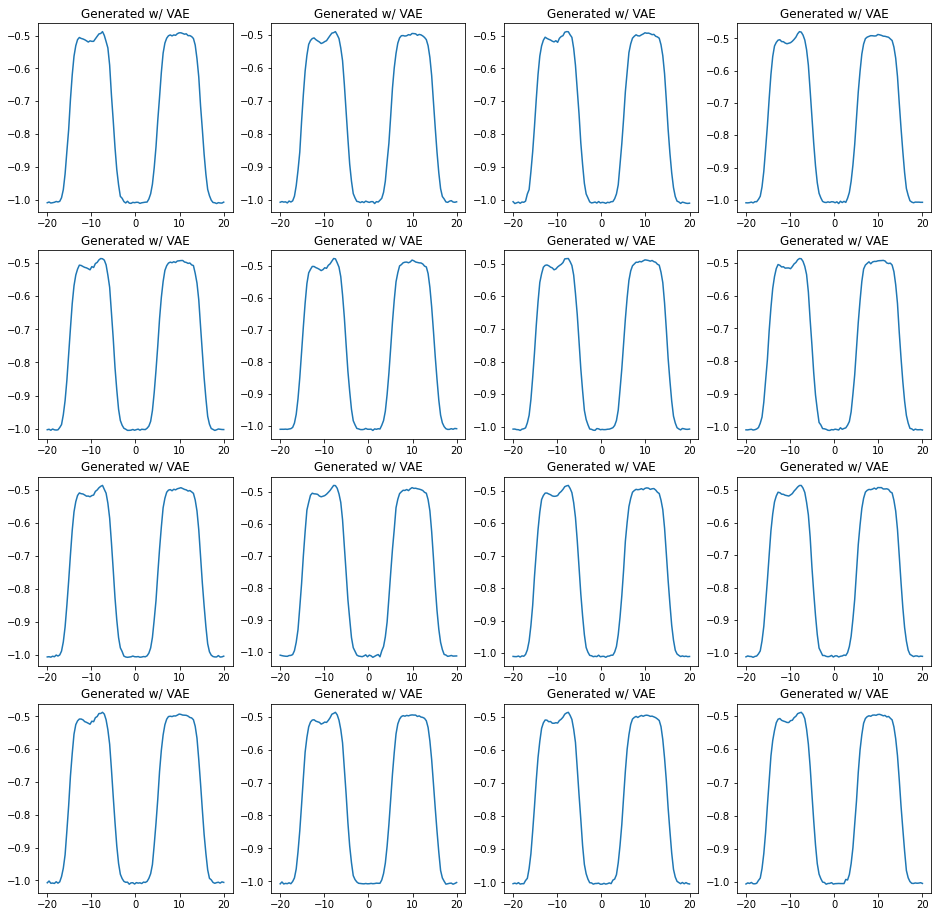

In [11]:
net.eval()
with torch.no_grad():
    num_generated_images = 16   
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    batch_x_0 = net(None, train=False, num_gen=num_generated_images)[0]
    ###############################################
    # YOUR CODE ENDS
    ###############################################
    print('batch_x_0',batch_x_0.size())
    batch_x_0 = batch_x_0.cpu()

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=1,0,1; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=2,0,2; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=3,0,3; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=0,1+0,4; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=1,1+0,5; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=2,1+0,6; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=3,1+0,7; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=0,2+0,8; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=1,2+0,9; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=2,2+0,10; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=3,2+0,11; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=0,3+0,12; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=1,3+0,13; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=2,3+0,14; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=3,3+0,15; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
plt.show()
